<a href="https://colab.research.google.com/github/DrueStaples08/Weight_Predictor/blob/master/Predicting_Weight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Use the features of gender and height to try and predict weight

#Import Packages

In [0]:
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [0]:
%matplotlib inline

In [0]:
dff = pd.read_csv('weight-height.csv')

In [0]:
df = dff

#Data Exploration

In [0]:
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [0]:
df.describe()

,Height,Weight
count,10000.000000,10000.000000
mean,66.367560,161.440357
std,3.847528,32.108439
min,54.263133,64.700127
25%,63.505620,135.818051
50%,66.318070,161.212928
75%,69.174262,187.169525
max,78.998742,269.989699


In [0]:
df.groupby('Gender')[['Height', 'Weight']].mean()

,Height,Weight
Gender,,
Female,63.708774,135.860093
Male,69.026346,187.020621


In [0]:
ProfileReport(df)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,3
Number of observations,10000
Total Missing (%),0.0%
Total size in memory,234.5 KiB
Average record size in memory,24.0 B
Numeric,1
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,1


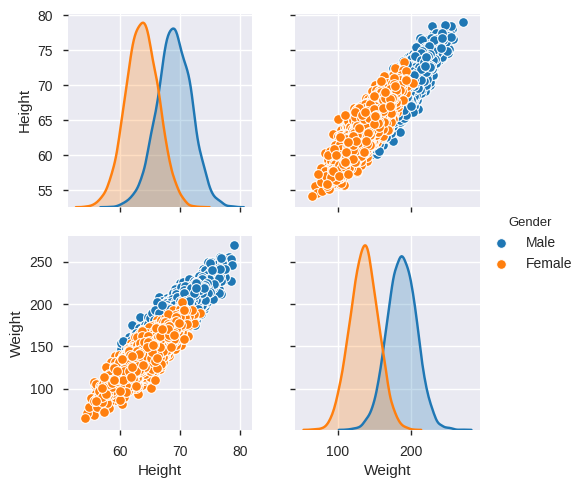

In [0]:
sns.pairplot(df, hue='Gender')

In [0]:
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


#Data Preparation

In [0]:
#shuffle df and reset the index 
df_shuf = shuffle(df)
df_res = df_shuf.reset_index(drop=True, inplace=False)

In [0]:
df_res.head()

,Gender,Height,Weight
0,Female,62.481233,122.605321
1,Male,73.749537,197.605875
2,Female,61.837097,136.773826
3,Female,64.755393,140.547045
4,Female,64.102013,141.745050


In [0]:
#one hot encode gender
df['Gender'].value_counts()

Female    5000
Male      5000
Name: Gender, dtype: int64

In [0]:
gender = pd.get_dummies(df['Gender'])
gender.head()

,Female,Male
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [0]:
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [0]:
df_no_gen = df.iloc[:,1:]
df_no_gen.head()

,Height,Weight
0,73.847017,241.893563
1,68.781904,162.310473
2,74.110105,212.740856
3,71.730978,220.042470
4,69.881796,206.349801


In [0]:
#merge the numeric feature, the one hot encoded feature, and the label 'weight'
df_2 = df_no_gen.merge(gender, right_index=True, left_index=True)

In [0]:
df_2.head()

,Height,Weight,Female,Male
0,73.847017,241.893563,0,1
1,68.781904,162.310473,0,1
2,74.110105,212.740856,0,1
3,71.730978,220.042470,0,1
4,69.881796,206.349801,0,1


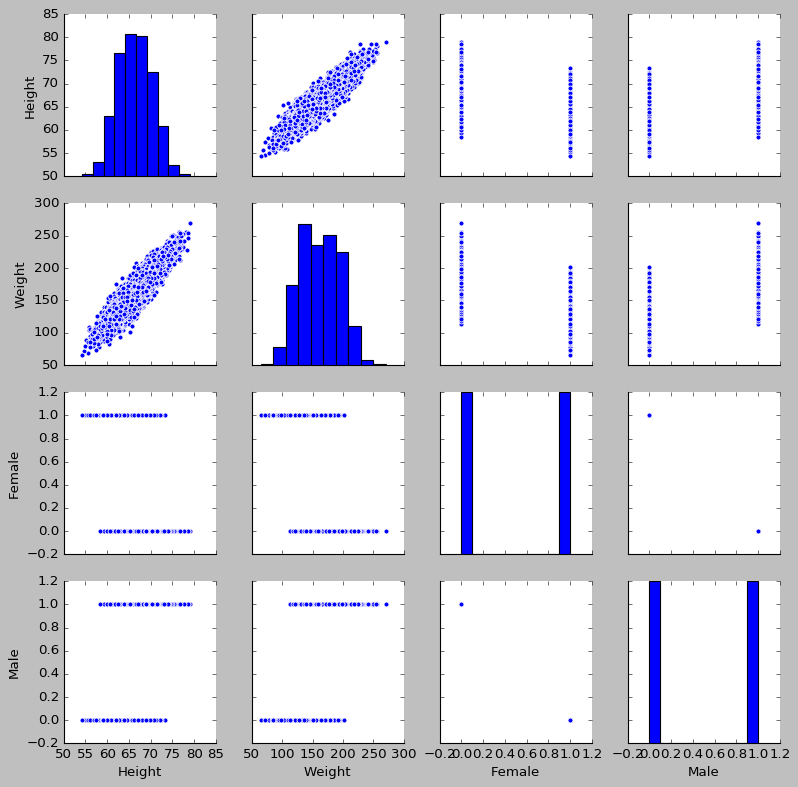

In [0]:
plt.style.use('classic')
sns.pairplot(df_2)

In [0]:
df_2.head()

,Height,Weight,Female,Male
0,73.847017,241.893563,0,1
1,68.781904,162.310473,0,1
2,74.110105,212.740856,0,1
3,71.730978,220.042470,0,1
4,69.881796,206.349801,0,1


In [0]:
#rearrange data so label 'weight' is at the end

new_cols = df_2.columns.tolist()
new_cols

['Height', 'Weight', 'Female', 'Male']

In [0]:
new_ord = new_cols[2:] + new_cols[:2]
new_ord

['Female', 'Male', 'Height', 'Weight']

In [0]:
df_3 = df_2[new_ord]
df_3.head()

,Female,Male,Height,Weight
0,0,1,73.847017,241.893563
1,0,1,68.781904,162.310473
2,0,1,74.110105,212.740856
3,0,1,71.730978,220.042470
4,0,1,69.881796,206.349801


In [0]:
#Feature Engineering --> remove outliers
df_3_rs = df_3[abs(zscore(df_3) < 3).all(axis=1)]
df_4 = df_3_rs.reset_index(inplace=False, drop=True)
df_4.head()

,Female,Male,Height,Weight
0,0,1,73.847017,241.893563
1,0,1,68.781904,162.310473
2,0,1,74.110105,212.740856
3,0,1,71.730978,220.042470
4,0,1,69.881796,206.349801


In [0]:
#orig df,    after removing outliers
df_3.shape, df_4.shape

((10000, 4), (9995, 4))

In [0]:
#scale only the 'height' column 
df_h = df_4['Height']
df_rs = df_h.values.reshape(-1,1)
sc = StandardScaler()
sc_df = sc.fit_transform(df_rs)
sc_df

array([[ 1.95005027],
       [ 0.6305442 ],
       [ 2.01858708],
       ...,
       [-0.64957266],
       [ 0.69628073],
       [-1.15072534]])

In [0]:
height_col = pd.DataFrame(data=sc_df, columns=['Height'])
height_col.head()

,Height
0,1.950050
1,0.630544
2,2.018587
3,1.398804
4,0.917076


In [0]:
gender_col = df_4.iloc[:,:2]
gender_col.head()

,Female,Male
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [0]:
label = df['Weight']
label.head()

0    241.893563
1    162.310473
2    212.740856
3    220.042470
4    206.349801
Name: Weight, dtype: float64

In [0]:
#merge the gender and height dataframes together
df_5 = gender_col.merge(height_col, left_index=True, right_index=True)
df_5

,Female,Male,Height
0,0,1,1.950050
1,0,1,0.630544
2,0,1,2.018587
3,0,1,1.398804
4,0,1,0.917076
...,...,...,...
9990,1,0,-0.049189
9991,1,0,0.183837
9992,1,0,-0.649573
9993,1,0,0.696281


In [0]:
#pca
#our features are called 'df_5' and our label is called 'label'
pca = PCA(.95)
sub_a = pca.fit_transform(df_5)
sub_a

array([[-2.0326405 , -0.41420892],
       [-0.90707479,  0.27441152],
       [-2.09110381, -0.44997673],
       ...,
       [ 0.92293725, -0.26387752],
       [-0.22510326, -0.96624803],
       [ 1.35043076, -0.00233724]])

In [0]:
sub_a.shape

(9995, 2)

In [0]:
#Subset A contains 2 principal components that were 
#...originally scaled down from 3 features

subset_a = pd.DataFrame(data=sub_a, columns=['PC 1', 'PC 2'])
subset_a

,PC 1,PC 2
0,-2.032641,-0.414209
1,-0.907075,0.274412
2,-2.091104,-0.449977
3,-1.562416,-0.126526
4,-1.151492,0.124877
...,...,...
9990,0.410797,-0.577204
9991,0.212022,-0.698815
9992,0.922937,-0.263878
9993,-0.225103,-0.966248


In [0]:
print(f'We have {pca.n_components_} principal components')

We have 2 principal components


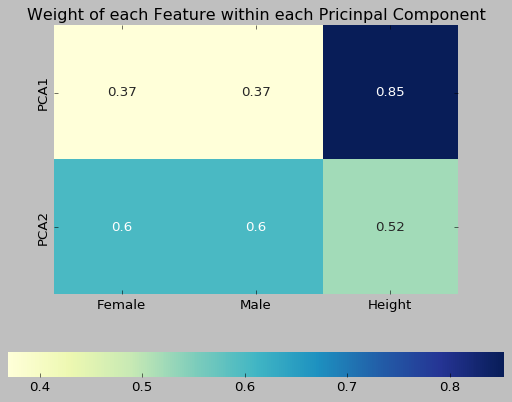

In [0]:
ax = sns.heatmap(abs(pca.components_),
                 annot=True,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pca.n_components_+1)],
                 xticklabels=list(df_5.columns),
                 cbar_kws={"orientation": "horizontal"})
plt.title('Weight of each Feature within each Pricinpal Component')
ax.set_aspect("equal")

In [0]:
df_4.head()

,Female,Male,Height,Weight
0,0,1,73.847017,241.893563
1,0,1,68.781904,162.310473
2,0,1,74.110105,212.740856
3,0,1,71.730978,220.042470
4,0,1,69.881796,206.349801


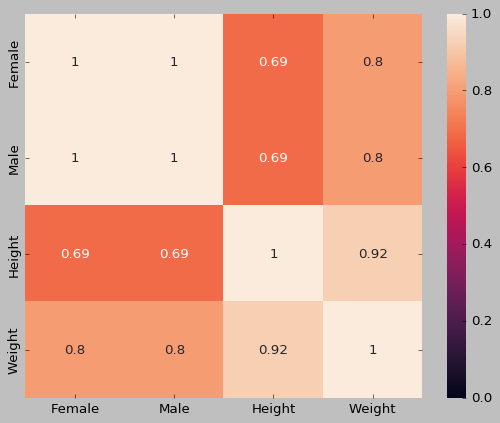

In [0]:
#heatmap
sns.heatmap(abs(df_4.corr()), annot=True, vmin=0, vmax=1)
plt.show()

In [0]:
#Subset B contains the single feature of 'Height'
subset_b = df_5['Height']
subset_b  = subset_b.values.reshape(-1,1)
subset_b, subset_b.shape, type(subset_b)

(array([[ 1.95005027],
        [ 0.6305442 ],
        [ 2.01858708],
        ...,
        [-0.64957266],
        [ 0.69628073],
        [-1.15072534]]), (9995, 1), numpy.ndarray)

In [0]:
#Subset C contains all three features
subset_c = df_5
subset_c.head()

,Female,Male,Height
0,0,1,1.950050
1,0,1,0.630544
2,0,1,2.018587
3,0,1,1.398804
4,0,1,0.917076


In [0]:
weight_label = df_4['Weight']
weight_label

0       241.893563
1       162.310473
2       212.740856
3       220.042470
4       206.349801
           ...    
9990    136.777454
9991    170.867906
9992    128.475319
9993    163.852461
9994    113.649103
Name: Weight, Length: 9995, dtype: float64

Coefficients between....

*   0.9 and 1.0 are highly correlated
*   0.5 and 0.7 are moderately correlated

All together we have found 3 subsets to work with:

*   Subset A	2 feats (PCA(.95))
*   Subset B	1 feat (Height)
*   Subset C	3 feats (Female, Male, Height)






Since this dataset isn't very complex, I feel comfortable with these three subsets. Otherwise I would consider using an ExtraTreesClassifier to find the Feature Importance

In [0]:
#Split up features and label for training and testing for subset_c 

train_X, test_X, train_y, test_y = train_test_split(subset_c, weight_label, test_size=0.2, random_state=13)

In [0]:
type(train_X), train_X.shape, type(train_y), train_y.shape

(pandas.core.frame.DataFrame, (7996, 3), pandas.core.series.Series, (7996,))

In [0]:
type(test_X), test_X.shape, type(test_y), test_y.shape

(pandas.core.frame.DataFrame, (1999, 3), pandas.core.series.Series, (1999,))

In [0]:
np.save('p2_c_train_X', train_X)

In [0]:
np.save('p2_c_train_y', train_y)

In [0]:
np.save('p2_c_test_X', test_X)

In [0]:
np.save('p2_c_test_y', test_y)

In [0]:
#Split up features and label for training and testing for subset_a

a_train_X, a_test_X, a_train_y, a_test_y = train_test_split(subset_a, weight_label, test_size=0.2, random_state=13)

In [0]:
type(a_train_X), a_train_X.shape, type(a_train_y), a_train_y.shape

(pandas.core.frame.DataFrame, (7996, 2), pandas.core.series.Series, (7996,))

In [0]:
type(a_test_X), a_test_X.shape, type(a_test_y), a_test_y.shape

(pandas.core.frame.DataFrame, (1999, 2), pandas.core.series.Series, (1999,))

In [0]:
np.save('p2_a_train_X', a_train_X)

In [0]:
np.save('p2_a_train_y', a_train_y)

In [0]:
np.save('p2_a_test_X', a_test_X)

In [0]:
np.save('p2_a_test_y', a_test_y)

In [0]:
#Split up features and label for training and testing for subset_b

b_train_X, b_test_X, b_train_y, b_test_y = train_test_split(subset_b, weight_label, test_size=0.2, random_state=13)

In [0]:
type(b_train_X), b_train_X.shape, type(b_train_y), b_train_y.shape

(numpy.ndarray, (7996, 1), pandas.core.series.Series, (7996,))

In [0]:
type(b_test_X), b_test_X.shape, type(b_test_y), b_test_y.shape

(numpy.ndarray, (1999, 1), pandas.core.series.Series, (1999,))

In [0]:
np.save('p2_b_train_X', b_train_X)

In [0]:
np.save('p2_b_train_y', b_train_y)

In [0]:
np.save('p2_b_test_X', b_test_X)

In [0]:
np.save('p2_b_test_y', b_test_y)

In [0]:
#load in data

In [0]:
a_train_X = np.load('p2_a_train_X.npy')

In [0]:
a_train_y = np.load('p2_a_train_y.npy')

In [0]:
a_test_X = np.load('p2_a_test_X.npy')

In [0]:
a_test_y = np.load('p2_a_test_y.npy')

In [0]:
b_train_X = np.load('p2_b_train_X.npy')

In [0]:
b_train_y = np.load('p2_b_train_y.npy')

In [0]:
b_test_X = np.load('p2_b_test_X.npy')

In [0]:
b_test_y = np.load('p2_b_test_y.npy')

In [0]:
c_train_X = np.load('p2_c_train_X.npy')

In [0]:
c_train_y = np.load('p2_c_train_y.npy')

In [0]:
c_test_X = np.load('p2_c_test_X.npy')

In [0]:
c_test_y = np.load('p2_c_test_y.npy')

#Machine Learning --> Linear Regression

####Subset A

In [22]:
linreg_1 = LinearRegression()
linreg_1

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
param_grid = {'fit_intercept': [False, True], 'normalize': [False, True]}
param_grid

{'fit_intercept': [False, True], 'normalize': [False, True]}

In [24]:
kf_model_1  = GridSearchCV(linreg_1, param_grid=param_grid, cv=10, n_jobs=50)
kf_model_1

GridSearchCV(cv=10, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=50,
             param_grid={'fit_intercept': [False, True],
                         'normalize': [False, True]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [25]:
kf_model_1.fit(a_train_X, a_train_y)

GridSearchCV(cv=10, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=50,
             param_grid={'fit_intercept': [False, True],
                         'normalize': [False, True]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [26]:
a_pred_y = kf_model_1.predict(a_test_X)
a_pred_y

array([104.07014146, 127.41680339, 173.35137245, ..., 201.39906538,
       185.26689732, 136.46373821])

In [27]:
pd.DataFrame({'Tested': a_test_y, 'Predicted': a_pred_y})

,Tested,Predicted
0,85.793085,104.070141
1,119.117424,127.416803
2,171.524042,173.351372
3,194.240362,172.995083
4,132.697317,128.305467
...,...,...
1994,142.206380,143.261284
1995,142.452571,135.866666
1996,182.174364,201.399065
1997,179.204782,185.266897


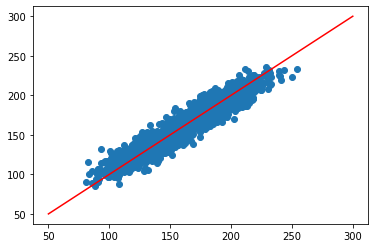

In [28]:
x = range(50,301,50)
y = x
plt.scatter(a_test_y, a_pred_y)
plt.plot(x,y, color='red')
plt.show()

In [29]:
#mean absolute error

metrics.mean_absolute_error(a_test_y, a_pred_y)

8.020949545134666

In [30]:
#mean squared error

metrics.mean_squared_error(a_test_y, a_pred_y)

99.93468232235509

In [31]:
#root mean squared error

np.sqrt(metrics.mean_squared_error(a_test_y, a_pred_y))

9.996733582643637

In [32]:
#adjusted r squared

metrics.r2_score(a_test_y, a_pred_y)

0.9013201586271592

In [33]:
#model's best parameters

kf_model_1.best_params_

{'fit_intercept': True, 'normalize': False}

In [34]:
#model's coefficients
#The coefficiants are negative. Why?
#In scikit learn, a decision was made to have all 
#outputs for training be based on classification 
#accuracy instead of preference of whether a user
#wants to find the loss OR accuracy.

kf_model_1.best_estimator_.coef_

array([-26.72518139,  -0.15326423])

In [35]:
#model's intercept

kf_model_1.best_estimator_.intercept_

161.3587398891754

In [36]:
kf_model_1.best_score_

0.9024190524110856

####Subset B

In [68]:
linreg_2 = LinearRegression()
linreg_2

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
param_grid = {'fit_intercept': [True, False], 'normalize': [True, False]}

In [70]:
kf_model = GridSearchCV(linreg_2, param_grid=param_grid, cv=10, n_jobs=50)
kf_model

GridSearchCV(cv=10, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=50,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [71]:
kf_model.fit(b_train_X, b_train_y)

GridSearchCV(cv=10, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=50,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [72]:
b_y_pred = kf_model.predict(b_test_X)
b_y_pred

array([ 99.73189457, 129.99129108, 164.20166641, ..., 200.55402649,
       179.64526997, 141.71694112])

In [73]:
kf_model.best_estimator_.coef_

array([29.65081752])

In [74]:
kf_model.best_estimator_.intercept_

161.32695990453792

In [75]:
kf_model.best_score_

0.8543523704641366

In [76]:
kf_model.best_estimator_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [77]:
kf_model.best_params_

{'fit_intercept': True, 'normalize': True}

In [79]:
pa_1 = pd.DataFrame({'Predicted': b_y_pred, 'Actual': b_test_y})
pa_1.head(10)

,Predicted,Actual
0,99.731895,85.793085
1,129.991291,119.117424
2,164.201666,171.524042
3,189.064885,194.240362
4,131.143080,132.697317
5,190.551095,190.585377
6,142.419620,140.642935
7,122.921919,139.105837
8,201.758726,196.672557
9,183.357909,205.699461


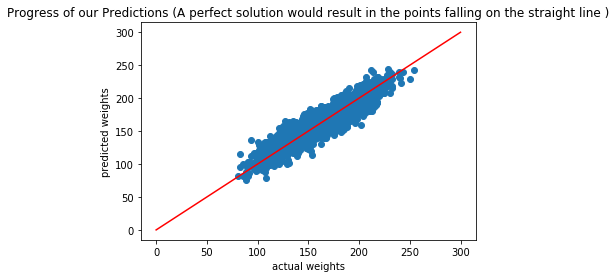

In [82]:
#plt.style.use('classic')
x = np.linspace(0,300,100)
y = x
plt.scatter(b_test_y, b_y_pred)
plt.plot(x,y, color='red')
plt.xlabel('actual weights')
plt.ylabel('predicted weights')
plt.title('Progress of our Predictions (A perfect solution would result in the points falling on the straight line )')
plt.show()

In [83]:
#mean absolute error
metrics.mean_absolute_error(b_test_y, b_y_pred)

9.726938017123206

In [84]:
#mean squared error 
metrics.mean_squared_error(b_test_y, b_y_pred)

147.49721981731224

In [85]:
#root mean squared error
np.sqrt(metrics.mean_squared_error(b_test_y, b_y_pred))

12.144843342641858

In [86]:
#adjusted r^2
metrics.r2_score(b_test_y, b_y_pred)

0.8543548454223535

####Subset C

In [37]:
linreg_3 = LinearRegression()
linreg_3

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
param_grid = {'fit_intercept': [True, False], 'normalize': [True, False]}

In [39]:
kf_model = GridSearchCV(linreg_3, param_grid=param_grid, cv=10, n_jobs=50)
kf_model

GridSearchCV(cv=10, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=50,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [40]:
kf_model.fit(c_train_X, c_train_y)

GridSearchCV(cv=10, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=50,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [41]:
c_pred_y = kf_model.predict(c_test_X)
c_pred_y

array([104.06103516, 127.40771484, 173.36108398, ..., 201.40893555,
       185.27661133, 136.45483398])

In [42]:
pd.DataFrame({'Actual': c_test_y, 'Predicted': c_pred_y})

,Actual,Predicted
0,85.793085,104.061035
1,119.117424,127.407715
2,171.524042,173.361084
3,194.240362,172.986328
4,132.697317,128.296387
...,...,...
1994,142.206380,143.252441
1995,142.452571,135.857666
1996,182.174364,201.408936
1997,179.204782,185.276611


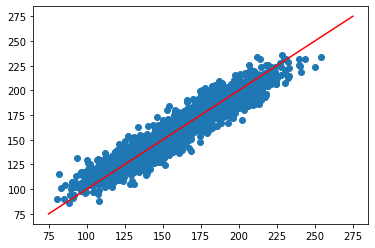

In [43]:
x = range(75,276,25)
y = x 
plt.scatter(c_test_y, c_pred_y)
plt.plot(x,y,color='red')
plt.show()

In [44]:
kf_model.best_estimator_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [45]:
kf_model.best_params_

{'fit_intercept': True, 'normalize': True}

In [46]:
kf_model.best_score_

0.9024207352344742

In [47]:
metrics.mean_absolute_error(c_test_y, c_pred_y)

8.021070326955545

In [48]:
metrics.mean_squared_error(c_test_y, c_pred_y)

99.93821640752233

In [49]:
np.sqrt(metrics.mean_squared_error(c_test_y, c_pred_y))

9.996910343077122

In [50]:
metrics.r2_score(c_test_y, c_pred_y)

0.9013166689181252

In [51]:
coeff = kf_model.best_estimator_.coef_
coeff

array([1.11198846e+12, 1.11198846e+12, 2.28772066e+01])

In [52]:
kf_model.best_estimator_.intercept_

-1111988463604.087

In [53]:
pd.DataFrame({'coefficients': coeff}, index=['Female', 'Male', 'Height'])

,coefficients
Female,1.111988e+12
Male,1.111988e+12
Height,2.287721e+01


In [59]:
c_test_X

array([[ 1.        ,  0.        , -2.07734796],
       [ 1.        ,  0.        , -1.0568231 ],
       [ 0.        ,  1.        ,  0.09695201],
       ...,
       [ 0.        ,  1.        ,  1.32296745],
       [ 0.        ,  1.        ,  0.61780118],
       [ 1.        ,  0.        , -0.6613652 ]])

In [65]:
 #remember, our height feature was scaled. therefore you will need to include a number from -1 to 1

kf_model.predict([[1,0,.5]])

array([163.02368164])

#Conclusion

Metrics 

*   Mean Absolute Error - absolute distance between predictions and actual truth
It has a linear mesure of fit and every residual is treated proportionately

"Like the RMSE (which will be explained later), the MAE is an absolute measure of fit. 'It can be interpreted as the standard deviation of the unexplained variance, and has the useful property of being in the same units as the response variable.'
Or in layman’s term, we should expect our prediction to be off by 8.02 lbs (on average) from the ground truth (based on the problem above)."

"Because we use the absolute value of the residual, the MAE does not indicate underperformance or overperformance of the model (whether or not the model under or overshoots actual data). Each residual contributes proportionally to the total amount of error, meaning that larger errors will contribute linearly to the overall error."


*   Root Mean Squared Error - square rooted distance between predictions and actual
It has a linear measure of fit, and outliers are penalized more
"Notice that the RMSE is larger than the MAE. Since the RMSE is squaring the difference between the predictions and the ground truth, any significant difference is made more substantial when it is being squared. RMSE is more sensitive to outliers. Hence, if the outliers are undesirable, the RMSE better evaluates how well your model is performing."


*   Mean Squared Error - squared distance between predictions and actual truth 
It has a quadratic measure of fit, and it penalizes outliers more 



*   R Squared - If you like to understand how well the independent variables “explain” the variance in your model, the R-Squared formula can be powerful.

Since we already removed outliers, we wont need to square the errors. Instead treat the data as linear. Use Mean Absoluter Error. 

*   A	8.020949545134666	2 feats

*   B	9.726938017123206	1 feat

*   C	8.021070326955545	3 feats

Our Subset A has the best results, but Subset C is pretty darn close!


#References

*   datacareer.ch (I could not find the author), How to find coefficients and intercept with GridSearchCV/RandomizedSearchCV, https://www.datacareer.ch/blog/ridge-and-lasso-in-python/


*   Alex Guanga, Understand Regression Metrics, https://becominghuman.ai/understand-regression-performance-metrics-bdb0e7fcc1b3


*   Manoj Kumar Dobbali, Understanding Regression Metrics, https://towardsdatascience.com/metrics-to-understand-regression-models-in-plain-english-part-1-c902b2f4156f


